# EfficientNetB7

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#DataScience Libraries                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        #Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

#Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam

#System Libraries
from pathlib import Path
import os.path

#Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [ ]:
#Seed Everything means, Random Parts of our Code always give the same results
def seed_everything(seed = 42):

    #Seed Value for Tensorflow
    tf.random.set_seed(seed)

    #Seed Value for NumPy
    np.random.seed(seed)

    #Seed Value for Random
    random.seed(seed)

    #Seeting TensorFlow to use only a single thread at a time
    #Multiple Threads at a time troubles seeding
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

# Getting Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-06-05 05:10:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-05 05:10:57 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Loading Data

In [ ]:
#Batch Size refers to the number of examples used in one iteration
BATCH_SIZE = 32
#Target Size refers to the dimesion of the input and output data
TARGET_SIZE = (224, 224)

In [ ]:
import zipfile
import os

zip_file = '/content/drive/MyDrive/English Reduced Dataset/raw-img.zip'
extract_dir = '/content'  # Directory where you want to extract the files

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check the extracted files
os.listdir(extract_dir)


['.config',
 '__pycache__',
 'drive',
 'Output',
 'raw-img',
 'helper_functions.py',
 'sample_data']

In [ ]:
#Walk through each directory
dataset = "/content/raw-img"
walk_through_dir(dataset)

There are 10 directories and 0 images in '/content/raw-img'.
There are 0 directories and 311 images in '/content/raw-img/Spider'.
There are 0 directories and 325 images in '/content/raw-img/Chicken'.
There are 0 directories and 401 images in '/content/raw-img/Horse'.
There are 0 directories and 348 images in '/content/raw-img/Cow'.
There are 0 directories and 535 images in '/content/raw-img/Dog'.
There are 0 directories and 390 images in '/content/raw-img/Elephant'.
There are 0 directories and 225 images in '/content/raw-img/Sheep'.
There are 0 directories and 491 images in '/content/raw-img/Cat'.
There are 0 directories and 441 images in '/content/raw-img/Squirrel'.
There are 0 directories and 484 images in '/content/raw-img/Butterfly'.


#Placing Data into a Dataframe

###The first column **'filepaths'** contains the file path location of each individual images. The second column **'labels'**, contains the class label of the corresponding image from the file path

In [ ]:
def convert_path_to_df(dataset):
  image_dir = Path(dataset)

  #Getting filepaths
  filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

  #Now Getting Their Labels
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

  filepaths = pd.Series(filepaths, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  #Concatenating
  image_df = pd.concat([filepaths, labels], axis=1)
  return image_df

image_df = convert_path_to_df(dataset)

In [ ]:
#Exception handling for Corrupted Images

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Getting filepaths
    filepaths = list(image_dir.glob(r'**/*.*'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenating
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

dataset = "/content/raw-img"

image_df = convert_path_to_df(dataset)

<ipython-input-68-d1410959f554>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
<ipython-input-68-d1410959f554>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(label_counts.index, rotation=45)


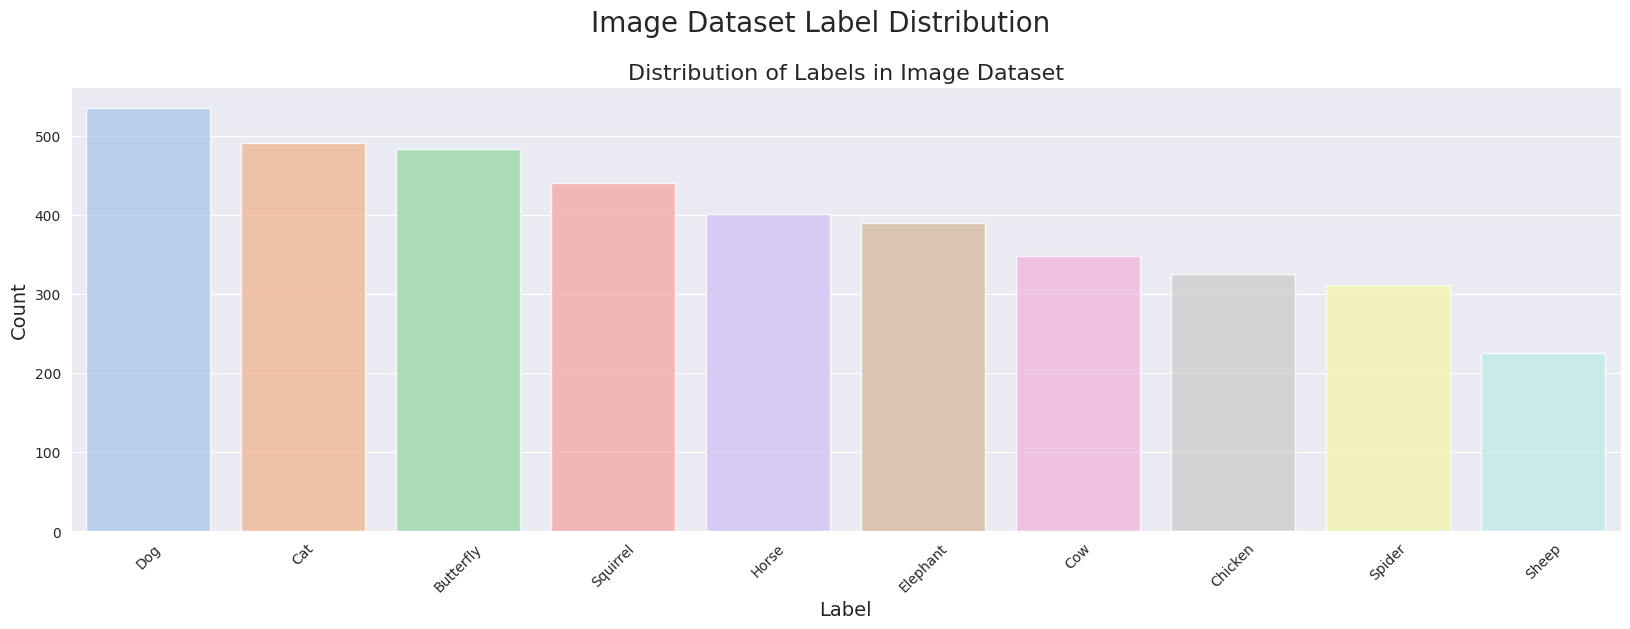

In [ ]:
label_counts = image_df['Label'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

fig.suptitle('Image Dataset Label Distribution', fontsize=20)

fig.subplots_adjust(top=0.85)

plt.show()

#Visualizing Images from the Dataset

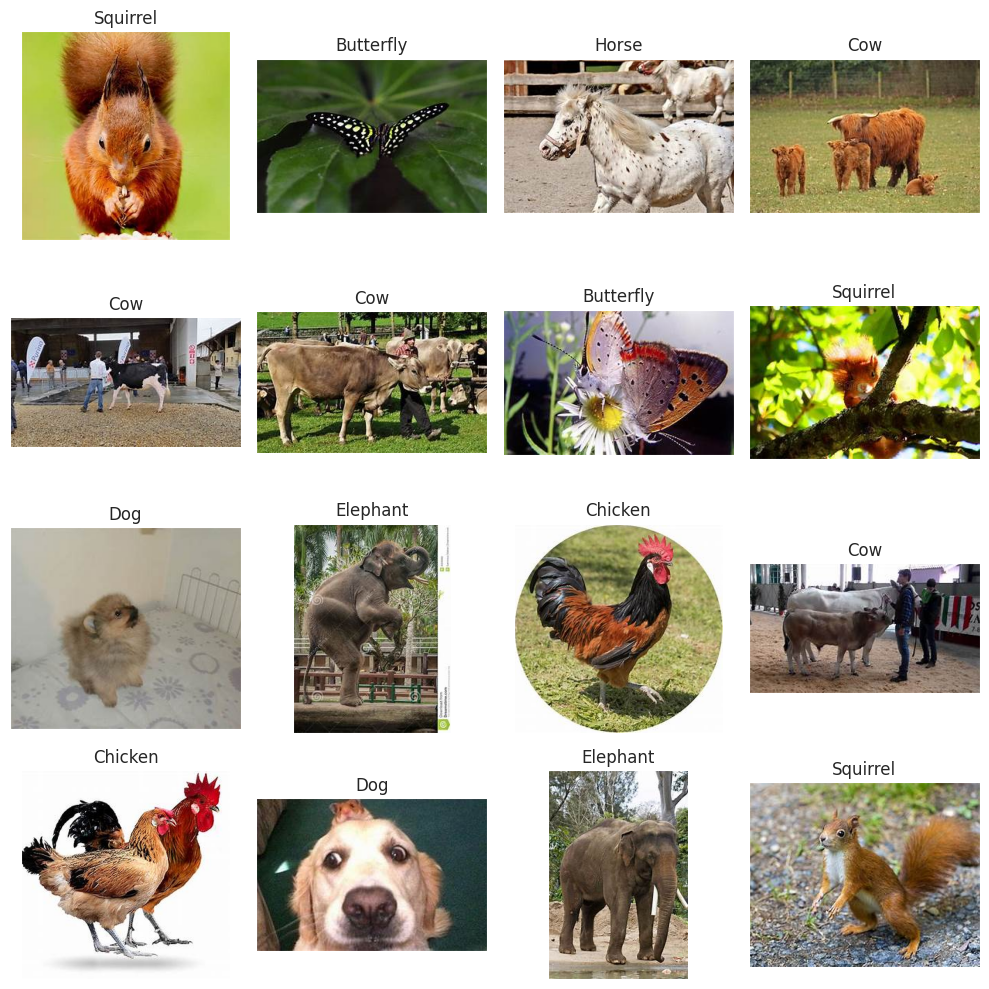

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

#Computing Error Rate

In [ ]:
def compute_ela_cv(path, quality):    #Takes an image path and quality parameter, compresses the image, computes the absolute difference with the original, scales the difference, and returns the ELA image.
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    compressed_img = cv2.imread(temp_filename)

    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):  #it compresses the image, computes the difference with the original, and returns a normalized ELA image to highlight differences.
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):  # Takes a directory path and optional file extension, and returns a random file path from that directory matching the extension.
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

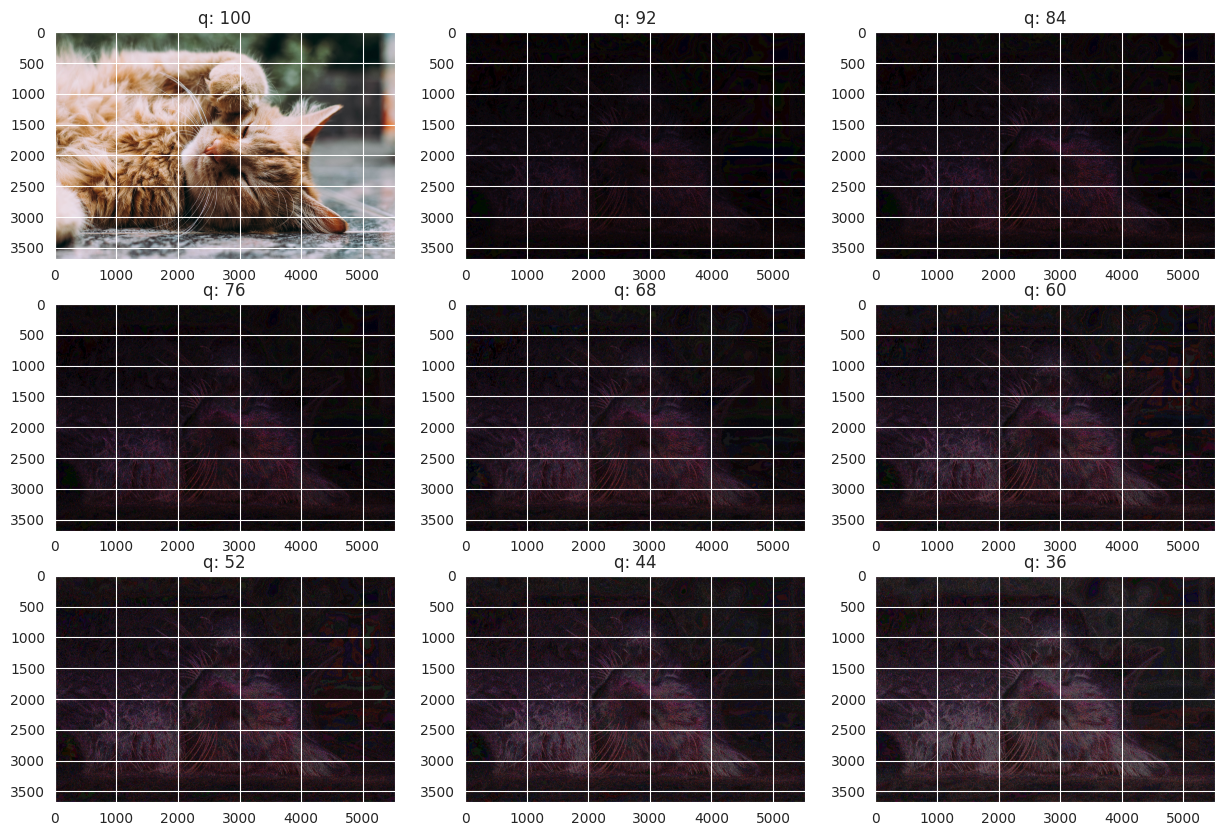

In [ ]:
# Taking a Random Image from the dataset
p = random_sample('/content/raw-img/Cat')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

#Data Preprocessing
#####Data is split into three different categories: Training, Validation and Testing. The training data is used to train the deep learning CNN model and its parameters are fine tuned with the validation data. Lastly, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
#Preprocessing train and test data

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2    #Splits Data 80% for Training, 20% for Validation
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
# Spliting the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2528 validated image filenames belonging to 10 classes.
Found 632 validated image filenames belonging to 10 classes.
Found 791 validated image filenames belonging to 10 classes.


In [ ]:
# Augmenting Data
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 [==============================] - 7s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20240605-051543
Epoch 1/100
79/79 [==============================] - 84s 672ms/step - loss: 3.3805 - accuracy: 0.1112 - val_loss: 2.3163 - val_accuracy: 0.2041 - lr: 1.0000e-05
Epoch 2/100
79/79 [==============================] - 38s 485ms/step - loss: 3.0925 - accuracy: 0.1559 - val_loss: 1.9141 - val_accuracy: 0.3718 - lr: 1.0000e-05
Epoch 3/100
79/79 [==============================] - 39s 499ms/step - loss: 2.7355 - accuracy: 0.2120 - val_loss: 1.6474 - val_accuracy: 0.5269 - lr: 1.0000e-05
Epoch 4/100
79/79 [==============================] - 38s 482ms/step - loss: 2.4278 - accuracy: 0.2907 - val_loss: 1.4740 - val_accuracy: 0.5902 - lr: 1.0000e-05
Epoch 5/100
79/79 [==============================] - 43s 544ms/step - loss: 2.2264 - accuracy: 0.3370 - val_loss: 1.2940 - val_accuracy: 0.6329 - lr: 1.0000e-05
Epoch 6/100
79/79 [==============================] - 39s 496ms/step - loss: 2.0351 - accuracy: 0.3841 - val_l

#Visual

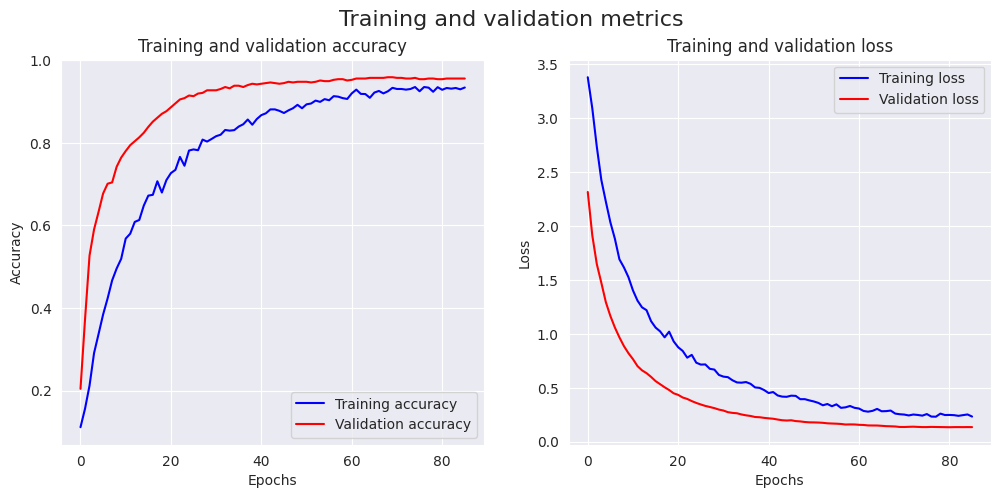

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

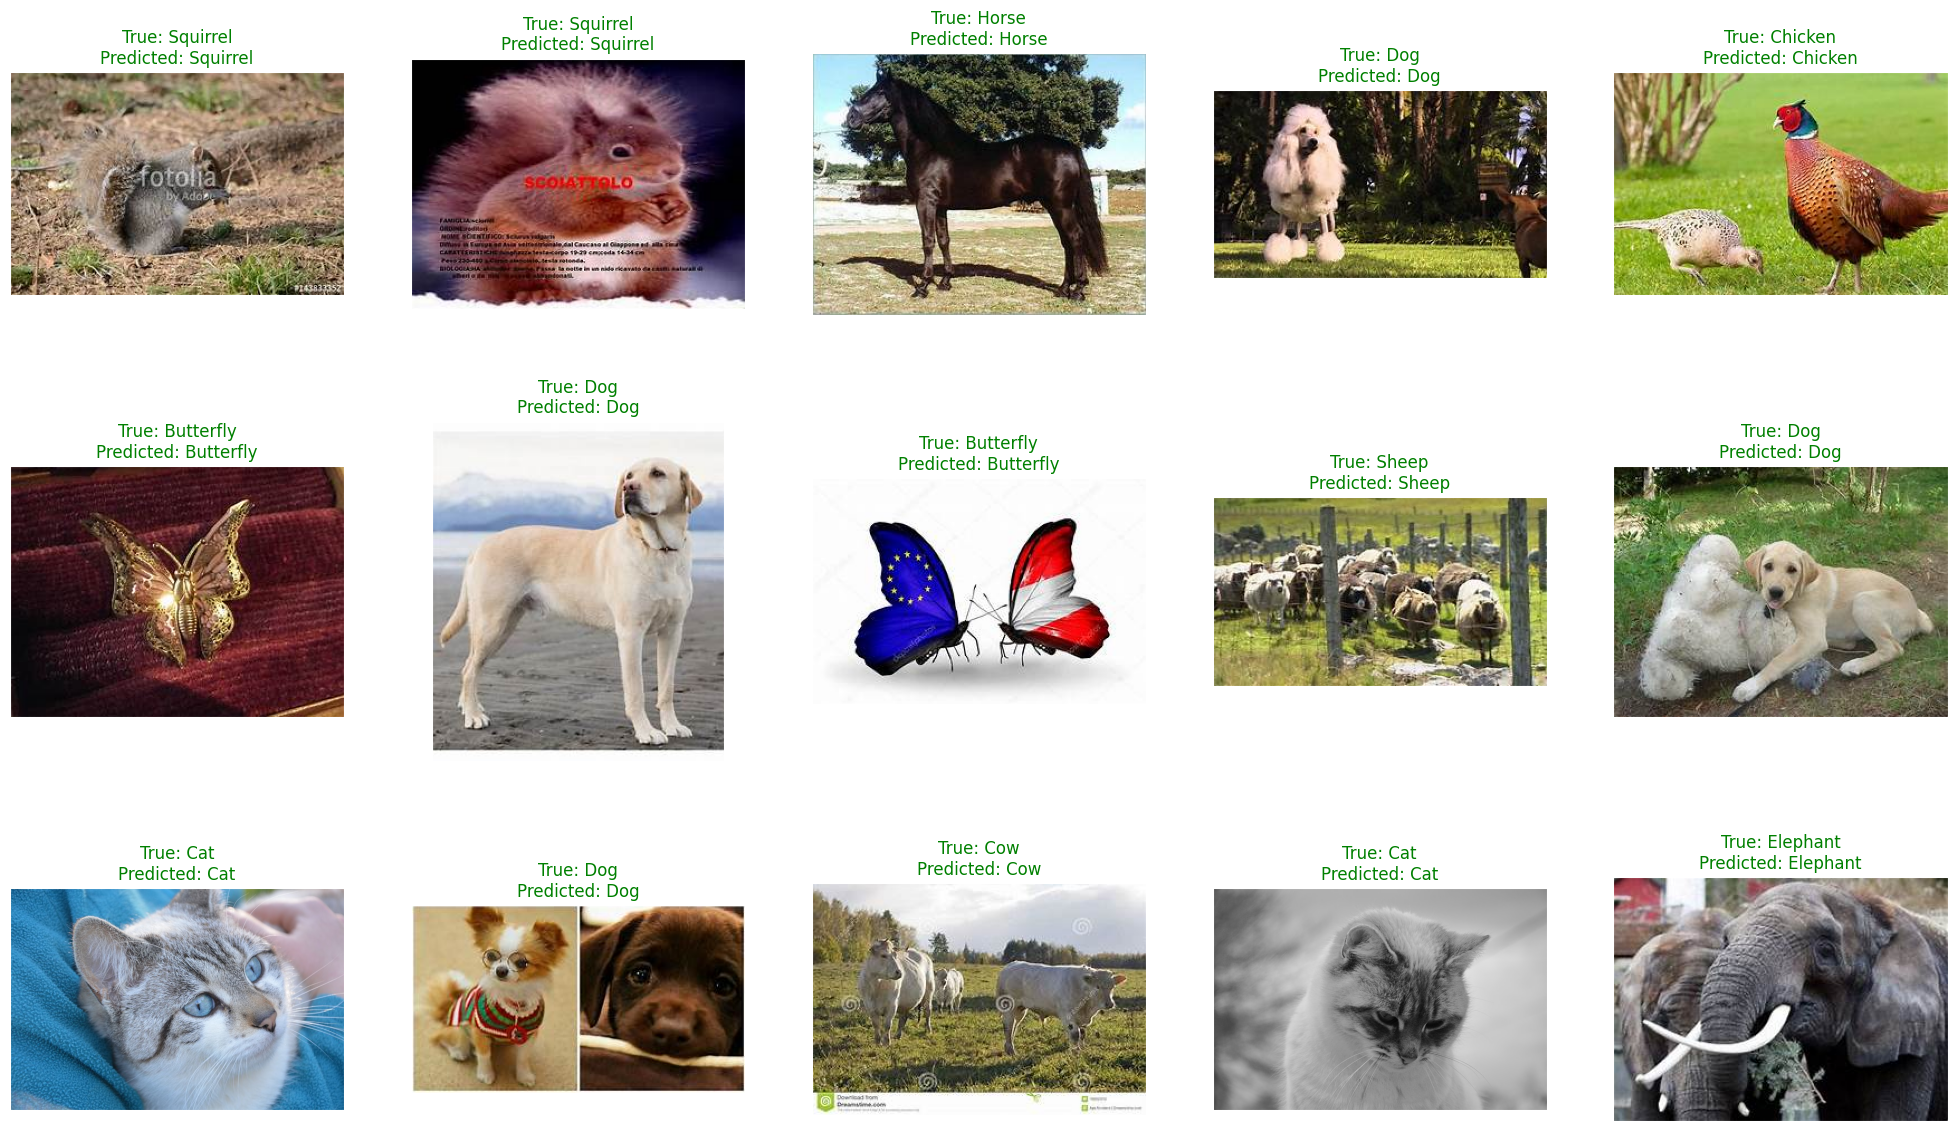

<Figure size 640x480 with 0 Axes>

In [ ]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   Butterfly       0.95      0.96      0.95        98
         Cat       0.97      0.98      0.97        94
     Chicken       0.98      0.96      0.97        68
         Cow       0.88      0.91      0.89        65
         Dog       0.95      0.98      0.97       104
    Elephant       1.00      0.96      0.98        81
       Horse       0.97      0.99      0.98        75
       Sheep       0.87      0.84      0.85        49
      Spider       0.95      0.96      0.96        78
    Squirrel       0.99      0.96      0.97        79

    accuracy                           0.96       791
   macro avg       0.95      0.95      0.95       791
weighted avg       0.96      0.96      0.96       791



In [ ]:
from keras.preprocessing import image

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch" of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    return cam_path


preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-34-591fbe4a8c9e>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


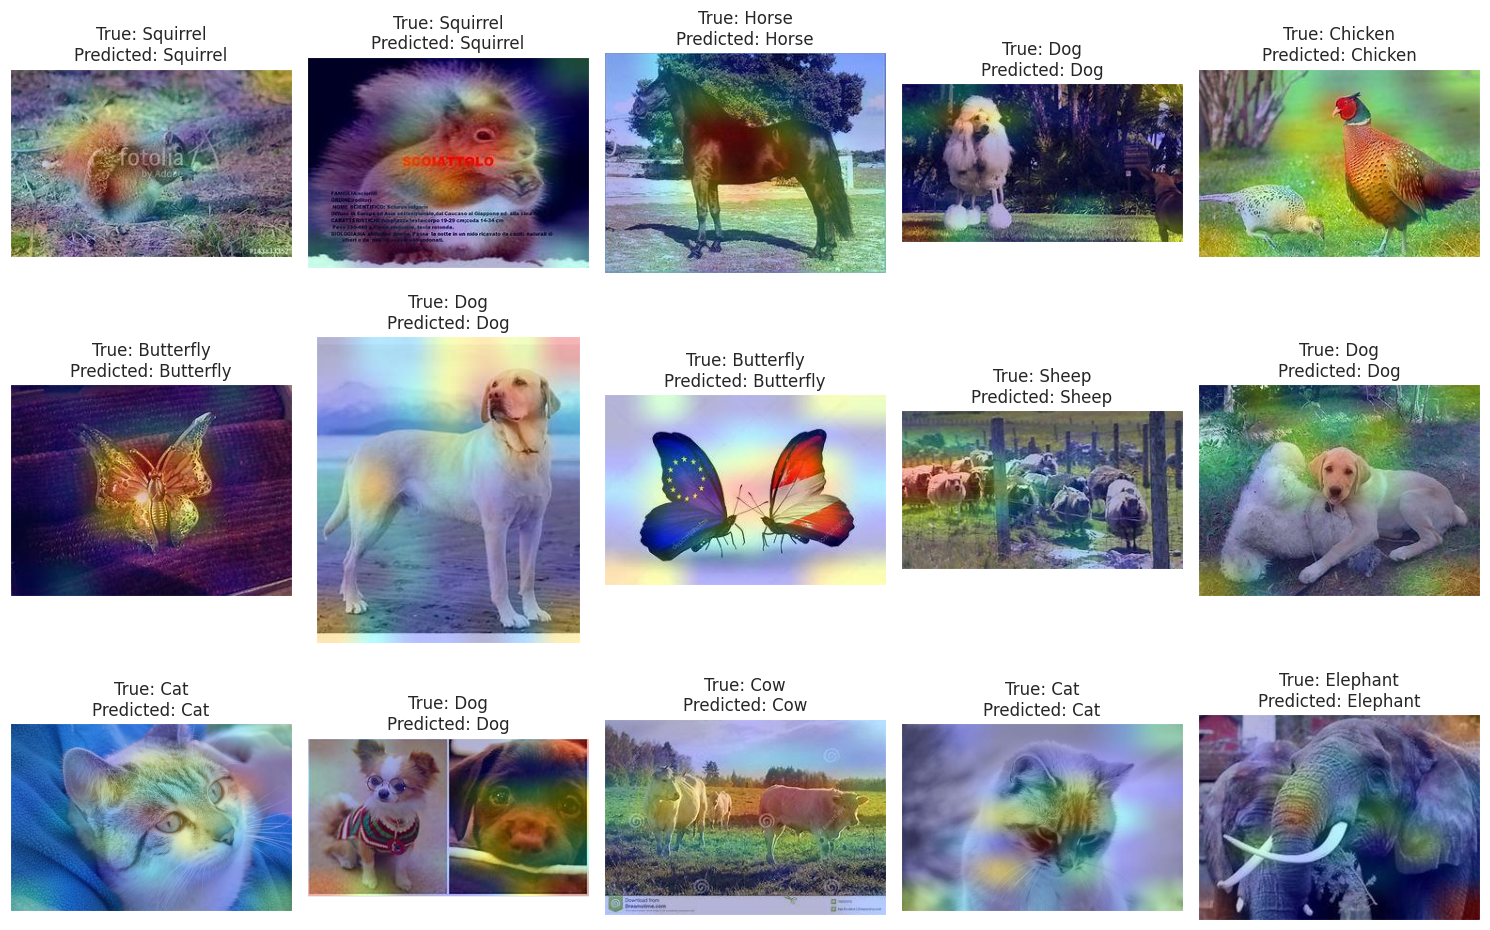

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image

In [ ]:
image_path = "/content/img.jpg"


In [ ]:
# Print the model's input shape
print(model.input_shape)

(None, 256, 256, 3)


Original shape: (318, 318, 3)


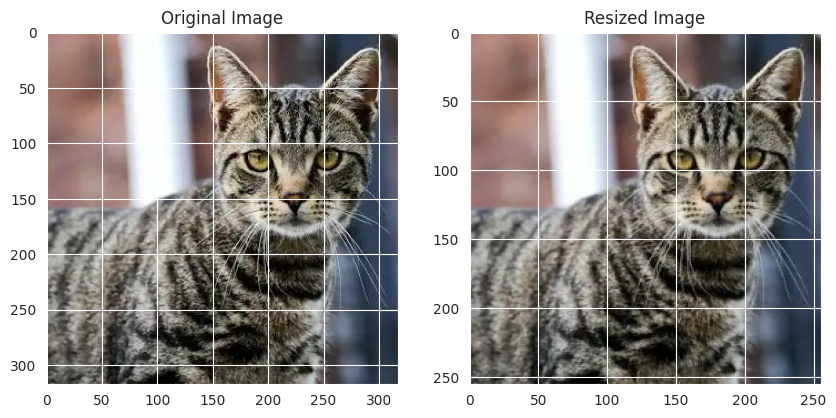

Resized shape: (1, 256, 256, 3)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)

# Original shape
print("Original shape:", image.shape)

# Resize the image to (224, 224)
resized_image = tf.image.resize(image, [224, 224])

# Display the original and resized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(tf.cast(image, tf.uint8))

plt.subplot(1, 2, 2)
plt.title("Resized Image")
plt.imshow(tf.cast(resized_image, tf.uint8))

plt.show()

resized_image = tf.expand_dims(resized_image, axis=0)

print("Resized shape:", resized_image.shape)

In [ ]:
# Use the loaded model to predict the class of the image
pred = model.predict(resized_image)

# Get the predicted class label
predicted_class = labels[np.argmax(pred)]

# Print the predicted class label
print(f"The Given Image is Predicted to be a: {predicted_class}")

1/1 [==============================] - 0s 35ms/step
The Given Image is Predicted to be a: Butterfly


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

name = "ResNet152V2"

num_classes = 10

batch_size = 32
img_height = 256
img_width = 256

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/raw-img",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/raw-img",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

pretrained_model = ResNet152V2(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
pretrained_model.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name=name)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)

Found 3951 files belonging to 10 classes.
Using 3161 files for training.
Found 3951 files belonging to 10 classes.
Using 790 files for validation.
Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9165

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 63s 489ms/step - loss: 0.2935 - accuracy: 0.9165 - val_loss: 0.1604 - val_accuracy: 0.9620
Epoch 2/50
99/99 [==============================] - 35s 351ms/step - loss: 0.0648 - accuracy: 0.9813 - val_loss: 0.1664 - val_accuracy: 0.9620
Epoch 3/50
99/99 [==============================] - 38s 377ms/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 0.1718 - val_accuracy: 0.9671
Epoch 4/50
99/99 [==============================] - 35s 349ms/step - loss: 0.0128 - accuracy: 0.9975 - val_loss: 0.1766 - val_accuracy: 0.9646


In [ ]:
import os

dataset_path = "/content/raw-img"

class_names = sorted(os.listdir(dataset_path))

true_labels = np.concatenate([y.numpy() for x, y in validation_dataset], axis=0)
predicted_labels = np.argmax(model.predict(validation_dataset), axis=1)

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


25/25 [==============================] - 11s 276ms/step
              precision    recall  f1-score   support

   Butterfly       0.09      0.09      0.09       101
         Cat       0.13      0.13      0.13        93
     Chicken       0.12      0.12      0.12        57
         Cow       0.09      0.08      0.08        74
         Dog       0.12      0.12      0.12        99
    Elephant       0.12      0.12      0.12        81
       Horse       0.10      0.12      0.11        86
       Sheep       0.02      0.02      0.02        46
      Spider       0.15      0.15      0.15        72
    Squirrel       0.09      0.09      0.09        81

    accuracy                           0.11       790
   macro avg       0.10      0.10      0.10       790
weighted avg       0.11      0.11      0.11       790



In [ ]:
model = tf.keras.models.load_model("ResNet152V2.h5")

def preprocess_image(img_path, img_height=256, img_width=256):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image(img_path, model, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return class_names[predicted_class]

class_names = ['Butterfly', 'Cat', 'Chicken', 'Cow', 'Dog',
               'Elephant', 'Horse', 'Sheep', 'Spider', 'Squirrel']

img_path = "/content/img1.jpg"

predicted_class= predict_image(img_path, model, class_names)
print(f"Given Image is Predicted to be a: {predicted_class}")

img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'load_img'